In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

from vivarium import Artifact


!date
!whoami
!pwd

Tue Oct 28 07:10:36 PDT 2025
tylerdy
/mnt/share/homes/tylerdy/vivarium_research_alzheimers/verification_and_validation


In [3]:
age_mapping = pd.read_csv(f"../age_bins.csv")  # downloaded with a different environment
# using vivarium_inputs.utility_data.get_age_bins;
# see also https://shiny.ihme.washington.edu/content/273/
# TODO: refactor this so that it does not require an extra .csv file
age_mapping

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,5,5,0 to 5,0.0,5.0
1,6,6,5 to 9,5.0,10.0
2,7,7,10 to 14,10.0,15.0
3,8,8,15 to 19,15.0,20.0
4,9,9,20 to 24,20.0,25.0
5,10,10,25 to 29,25.0,30.0
6,11,11,30 to 34,30.0,35.0
7,12,12,35 to 39,35.0,40.0
8,13,13,40 to 44,40.0,45.0
9,14,14,45 to 49,45.0,50.0


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [4]:
# %cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

In [5]:
locations = [
    "united_states_of_america",
    #              'china',
    #              'brazil',
    #              'japan',
    #             'sweden',
    #              'united_kingdom',
]


results_dirs = [
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/united_states_of_america/2025_10_27_13_05_02/results/"
]

artifact_dirs = [
    "/mnt/share/homes/abie/projects/2025/vivarium_csu_alzheimers/united_states_of_america.hdf"
]
artifact_dirs

['/mnt/share/homes/abie/projects/2025/vivarium_csu_alzheimers/united_states_of_america.hdf']

In [6]:
[x for x in os.listdir(results_dirs[0]) if "parquet" in x]

['counts_newly_eligible_for_bbbm_testing.parquet',
 'deaths.parquet',
 'counts_new_simulants.parquet',
 'ylls.parquet',
 'person_time_eligible_for_bbbm_testing.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'transition_count_treatment.parquet',
 'ylds.parquet',
 'counts_bbbm_tests.parquet',
 'person_time_treatment.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet',
 'person_time_ever_eligible_for_bbbm_testing.parquet',
 'counts_baseline_tests_among_eligible.parquet']

In [7]:
# age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
# art = Artifact(artifact_dirs[0],
#                filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
#               )

# age_dictionary = pd.DataFrame()
# age_dictionary['age_group_id'] = age_group_ids
# age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
# age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
# artifact = art.load('population.structure').reset_index()
# artifact = artifact.loc[artifact.age_start > 29].reset_index()
# age_dictionary['age_start'] = artifact.age_start
# age_dictionary['age_end'] = artifact.age_end

# # tweak final row to be named age group 95_plus
# assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
# age_dictionary.loc[13, 'age_group'] = '95_plus'

# age_dictionary.tail()

age_dictionary = age_mapping.copy()
age_dictionary["age_group"] = age_dictionary.age_group_name.str.lower().str.replace(
    " ", "_"
)
age_dictionary

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end,age_group
0,5,5,0 to 5,0.0,5.0,0_to_5
1,6,6,5 to 9,5.0,10.0,5_to_9
2,7,7,10 to 14,10.0,15.0,10_to_14
3,8,8,15 to 19,15.0,20.0,15_to_19
4,9,9,20 to 24,20.0,25.0,20_to_24
5,10,10,25 to 29,25.0,30.0,25_to_29
6,11,11,30 to 34,30.0,35.0,30_to_34
7,12,12,35 to 39,35.0,40.0,35_to_39
8,13,13,40 to 44,40.0,45.0,40_to_44
9,14,14,45 to 49,45.0,50.0,45_to_49


In [8]:
age_group_ids = age_dictionary.query(
    "age_start >= 30 and age_start <= 95"
).age_group_id.values

## Verify that all simulants in the model have AD 

In [71]:
def load_df(measure):
    data = pd.DataFrame()
    #     import pdb; pdb.set_trace()
    for results_dir in results_dirs:
        temp = pd.read_parquet(
            results_dir + measure + ".parquet",
            #                                filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf')],
            #                                nrows=1000
        )
        display(temp)
        # just look at the baseline scenario for v&v purposes
        temp = temp[temp.scenario == "baseline"]

        # aggregate by summing value column over random seeds
        #         print(temp.columns)
        #         import pdb; pdb.set_trace()
        cols = [
            c
            for c in temp.columns
            if c not in ["value", "random_seed", "treatment", "artifact_path"]
        ]
        temp = temp.groupby(cols)["value"].sum().reset_index()

        temp["location"] = locations[results_dirs.index(results_dir)].title()
        temp["event_year"] = temp["event_year"].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [10]:
person_time = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time

/tmp/ipykernel_1580163/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,2,0.000000,United_States_Of_America
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,13,0.000000,United_States_Of_America
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,24,0.000000,United_States_Of_America
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,41,0.000000,United_States_Of_America
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,46,0.000000,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...
2024995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2060,Male,499,baseline,446,0.000000,United_States_Of_America
2024996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2060,Male,499,baseline,457,0.000000,United_States_Of_America
2024997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2060,Male,499,baseline,460,0.000000,United_States_Of_America
2024998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2060,Male,499,baseline,480,0.000000,United_States_Of_America


In [11]:
person_time.loc[
    person_time.sub_entity == "susceptible_to_alzheimers_disease_and_other_dementias"
].value.sum()

0.0

In [12]:
assert (
    person_time.loc[
        person_time.sub_entity
        == "susceptible_to_alzheimers_disease_and_other_dementias"
    ].value.sum()
    == 0
), "should be zero years of person-time susceptible"

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [13]:
person_time.groupby("sub_entity").value.sum()

/tmp/ipykernel_1580163/2876506740.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby("sub_entity").value.sum()


sub_entity
alzheimers_blood_based_biomarker_state        4.195343e+07
alzheimers_disease_state                      7.591689e+07
alzheimers_mild_cognitive_impairment_state    3.115427e+07
Name: value, dtype: float64

In [14]:
person_time.groupby(
    ["location", "event_year", "age_group", "sub_entity"]
).value.sum().unstack()

/tmp/ipykernel_1580163/1677760363.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby(


sub_entity                                     alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
United_States_Of_America 2025       25_to_29                                 0.000000   
                                    30_to_34                              1387.734428   
                                    35_to_39                              1718.099932   
                                    40_to_44                              1910.937714   
                                    45_to_49                              5897.746749   
...                                                                               ...   
                         2060       75_to_79                            239180.637919   
                                    80_to_84                            313444.610541   
                                    85_to_89                            243290.026010   
                                    90_to_94                            102260.331280   
                                    95_plus                              26745.155373   

sub_entity                                     alzheimers_disease_state  \
location                 event_year age_group                             
United_States_Of_America 2025       25_to_29                   0.000000   
                                    30_to_34                 324.884326   
                                    35_to_39                 500.780287   
                                    40_to_44                 707.570157   
                                    45_to_49                1113.177276   
...                                                                 ...   
                         2060       75_to_79              421477.119781   
                                    80_to_84              578227.827515   
                                    85_to_89              542555.329227   
                                    90_to_94              299752.629706   
                                    95_plus                95630.099932   

sub_entity                                     alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
United_States_Of_America 2025       25_to_29                                     0.000000  
                                    30_to_34                                  1078.795346  
                                    35_to_39                                   725.010267  
                                    40_to_44                                   760.388775  
                                    45_to_49                                  1929.872690  
...                                                                                   ...  
                         2060       75_to_79                                162585.670089  
                                    80_to_84                                228194.863792  
                                    85_to_89                                206525.278576  
                                    90_to_94                                105746.360027  
                                    95_plus                                  33272.739220  

[540 rows x 3 columns]

In [15]:
# assert np.all(person_time[~person_time.age_group.isin(['25_to_29', '30_to_34', '35_to_40'])
#                          ].groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [16]:
trans = load_df("transition_count_alzheimers_disease_and_other_dementias")
trans.loc[
    trans.sub_entity
    == "susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias"
].value.sum()

/tmp/ipykernel_1580163/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


0.0

In [17]:
# assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
#        'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [18]:
# assert np.all(trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [19]:
out_counts = (
    trans.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)
out_counts.columns = [c.split("_to_")[0] for c in out_counts.columns]
out_counts

/tmp/ipykernel_1580163/3292819502.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trans.groupby(["location", "event_year", "age_group", "sub_entity"])


alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
United_States_Of_America 2025       25_to_29                                      0.0   
                                    30_to_34                                    204.0   
                                    35_to_39                                    249.0   
                                    40_to_44                                    272.0   
                                    45_to_49                                    888.0   
...                                                                               ...   
                         2060       75_to_79                                  34773.0   
                                    80_to_84                                  45911.0   
                                    85_to_89                                  37275.0   
                                    90_to_94                                  15679.0   
                                    95_plus                                    4076.0   

                                               alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
United_States_Of_America 2025       25_to_29                                          0.0  
                                    30_to_34                                        309.0  
                                    35_to_39                                        188.0  
                                    40_to_44                                        183.0  
                                    45_to_49                                        501.0  
...                                                                                   ...  
                         2060       75_to_79                                      41754.0  
                                    80_to_84                                      57718.0  
                                    85_to_89                                      51650.0  
                                    90_to_94                                      24904.0  
                                    95_plus                                        7471.0  

[540 rows x 2 columns]

In [20]:
out_rates = (
    out_counts
    / person_time.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)
out_rates["alzheimers_blood_based_biomarker_state"].unstack()

/tmp/ipykernel_1580163/2654564655.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  / person_time.groupby(["location", "event_year", "age_group", "sub_entity"])


age_group                            25_to_29  30_to_34  35_to_39  40_to_44  \
location                 event_year                                           
United_States_Of_America 2025             NaN  0.147002  0.144928  0.142338   
                         2026             NaN  0.146953  0.144276  0.139152   
                         2027             NaN  0.161009  0.161923  0.136722   
                         2028             NaN  0.161782  0.175156  0.141074   
                         2029             NaN  0.168240  0.180947  0.133825   
                         2030             NaN  0.000000  0.183534  0.124020   
                         2031             NaN       NaN  0.191259  0.148490   
                         2032             NaN       NaN  0.173255  0.146681   
                         2033             NaN       NaN  0.202616  0.130511   
                         2034             NaN       NaN  0.246999  0.130731   
                         2035             NaN       NaN  0.000000  0.141593   
                         2036             NaN       NaN  0.000000  0.125842   
                         2037             NaN       NaN  2.006868  0.128440   
                         2038             NaN       NaN  0.000000  0.130013   
                         2039             NaN       NaN  0.000000  0.125722   
                         2040             NaN       NaN  0.668956  0.129928   
                         2041             NaN       NaN  0.000000  0.120122   
                         2042             NaN       NaN  0.000000  0.126089   
                         2043             NaN       NaN       NaN  0.140688   
                         2044             NaN       NaN       NaN  0.123329   
                         2045             NaN       NaN  0.000000  0.122497   
                         2046             NaN       NaN  0.000000  0.129251   
                         2047             NaN       NaN  0.000000  0.124883   
                         2048             NaN       NaN  0.000000  0.126782   
                         2049             NaN       NaN       NaN  0.125465   
                         2050             NaN       NaN       NaN  0.122267   
                         2051             NaN       NaN  0.000000  0.127873   
                         2052             NaN       NaN  0.401374  0.138028   
                         2053             NaN       NaN  0.000000  0.122950   
                         2054             NaN       NaN  0.000000  0.128620   
                         2055             NaN       NaN  0.000000  0.126406   
                         2056             NaN       NaN  0.000000  0.136200   
                         2057             NaN       NaN  0.000000  0.117275   
                         2058             NaN       NaN  0.000000  0.122546   
                         2059             NaN       NaN  0.501717  0.131113   
                         2060             NaN       NaN  0.000000  0.117728   

age_group                            45_to_49  50_to_54  55_to_59  60_to_64  \
location                 event_year                                           
United_States_Of_America 2025        0.150566  0.153897  0.141159  0.142388   
                         2026        0.144653  0.147971  0.151533  0.144943   
                         2027        0.143028  0.157674  0.150675  0.147927   
                         2028        0.147536  0.164628  0.145197  0.141173   
                         2029        0.152231  0.150619  0.150415  0.144511   
                         2030        0.151306  0.155774  0.143807  0.141259   
                         2031        0.147156  0.158732  0.151194  0.142369   
                         2032        0.149221  0.149918  0.144959  0.143263   
                         2033        0.152206  0.142104  0.144532  0.144104   
                         2034        0.153306  0.155164  0.145061  0.139577   
                         2035        0.154787  0.

In [21]:
1 / 3.85

0.2597402597402597

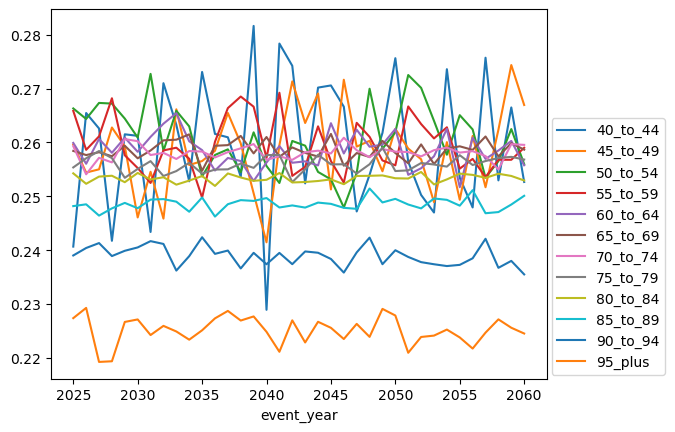

In [22]:
t = out_rates["alzheimers_mild_cognitive_impairment_state"].unstack()
t.loc["United_States_Of_America"].iloc[:, 3:].plot()
plt.legend(loc=(1.01, 0.01))

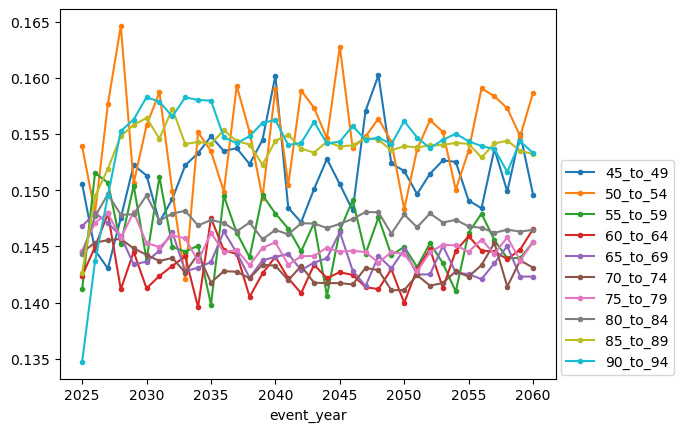

In [23]:
t = out_rates["alzheimers_blood_based_biomarker_state"].unstack()
t.loc["United_States_Of_America"].iloc[:, 4:14].plot(marker=".")
plt.legend(loc=(1.01, 0.01))

In [24]:
# prevalence \approx incidence * duration
prevalence_count = (
    person_time.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)

mci_duration_est = (
    prevalence_count["alzheimers_mild_cognitive_impairment_state"]
    / out_counts["alzheimers_blood_based_biomarker_state"]
)
mci_duration_est

/tmp/ipykernel_1580163/2467993286.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby(["location", "event_year", "age_group", "sub_entity"])


location                  event_year  age_group
United_States_Of_America  2025        25_to_29          NaN
                                      30_to_34     5.288212
                                      35_to_39     2.911688
                                      40_to_44     2.795547
                                      45_to_49     2.173280
                                                     ...   
                          2060        75_to_79     4.675630
                                      80_to_84     4.970375
                                      85_to_89     5.540584
                                      90_to_94     6.744458
                                      95_plus      8.163086
Length: 540, dtype: float64

In [25]:
new_sims = (
    load_df("counts_new_simulants")
    .groupby(
        [
            "location",
            "event_year",
            "age_group",
        ]
    )
    .value.sum()
)
# new_sims


bbbm_duration_est = (
    prevalence_count["alzheimers_blood_based_biomarker_state"] / new_sims
)
bbbm_duration_est

/tmp/ipykernel_1580163/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_1580163/2545667442.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(


location                  event_year  age_group
United_States_Of_America  2025        25_to_29             NaN
                                      30_to_34             inf
                                      35_to_39     1718.099932
                                      40_to_44        0.671447
                                      45_to_49        5.032207
                                                      ...     
                          2060        75_to_79        1.889054
                                      80_to_84        2.066731
                                      85_to_89        4.205823
                                      90_to_94        3.218466
                                      95_plus              inf
Length: 540, dtype: float64

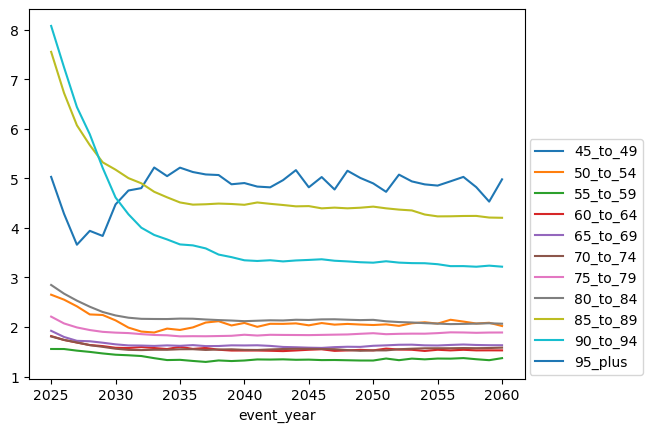

In [26]:
t = bbbm_duration_est.unstack()
t.loc["United_States_Of_America"].iloc[:, 4:].plot()
plt.legend(loc=(1.01, 00.01))

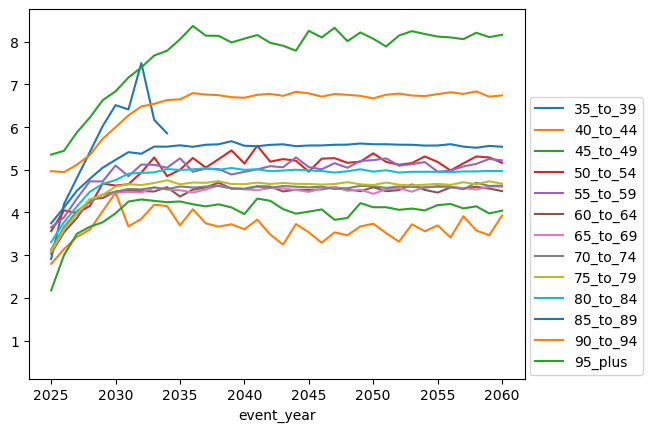

In [27]:
t = mci_duration_est.unstack()
t.loc["United_States_Of_America"].iloc[:, 2:].plot()
plt.legend(loc=(1.01, 0.01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [28]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id']#.isin(age_group_ids)
                     ]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

/tmp/ipykernel_1580163/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
<timed exec>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_1580163/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
<timed exec>:8: FutureWarning: The default of observed=False is deprecated and will 

CPU times: user 14.2 s, sys: 2.51 s, total: 16.7 s
Wall time: 11.3 s


In [29]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)

    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f"cause.all_causes.cause_specific_mortality_rate")
    b = art.load(
        f"cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate"
    )

    data1 = (a - b.droplevel(["year_start", "year_end"])).dropna()
    data2 = (
        data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
        .filter(["mean", "2.5%", "97.5%"])
        .reset_index()
    )
    data3 = data2.merge(age_dictionary, on=["age_start", "age_end"])
    data4 = data3  # .loc[data3['age_group_id'].isin(age_group_ids)]
    data4["measure"] = "acmr"
    data4["location"] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,Unnamed: 0,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2022,2023,0.000931,0.000911,0.000951,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
1,Female,30.0,35.0,2023,2024,0.000898,0.000875,0.000925,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
2,Female,30.0,35.0,2024,2025,0.000900,0.000871,0.000935,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
3,Female,30.0,35.0,2025,2026,0.000901,0.000865,0.000942,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
4,Female,30.0,35.0,2026,2027,0.000902,0.000856,0.000950,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,Male,90.0,95.0,2046,2047,0.187523,0.170802,0.206213,23,32,90 to 94,90_to_94,acmr,United_States_Of_America
750,Male,90.0,95.0,2047,2048,0.187622,0.170281,0.207026,23,32,90 to 94,90_to_94,acmr,United_States_Of_America
751,Male,90.0,95.0,2048,2049,0.187787,0.170087,0.207539,23,32,90 to 94,90_to_94,acmr,United_States_Of_America
752,Male,90.0,95.0,2049,2050,0.187738,0.169172,0.208122,23,32,90 to 94,90_to_94,acmr,United_States_Of_America


In [30]:
art_data = art_ocmr
location = "United_States_Of_America"
sex = "Female"
year = 2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [31]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030, 2040, 2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f"C{j}"
                plot_data = sim_data.loc[
                    (sim_data.location == location)
                    & (sim_data.event_year == year)
                    & (sim_data.sex == sex)
                ]
                if art_year is None:
                    art_plot = art_data.loc[
                        (art_data.location == location)
                        & (art_data.sex == sex)
                        & (art_data.year_start == year)
                    ]
                else:
                    art_plot = art_data.loc[
                        (art_data.location == location)
                        & (art_data.sex == sex)
                        & (art_data.year_start == art_year)
                    ]

                ax[i].fill_between(
                    plot_data.age_start,
                    plot_data["2.5%"],
                    plot_data["97.5%"],
                    alpha=0.2,
                    color=color,
                )
                ax[i].fill_between(
                    art_plot.age_start,
                    art_plot["2.5%"],
                    art_plot["97.5%"],
                    alpha=0.2,
                    color=color,
                )

                ax[i].plot(
                    art_plot.age_start,
                    art_plot["mean"],
                    linestyle="--",
                    label=f"Artifact {sex}",
                    color=color,
                    linewidth=3,
                )
                ax[i].plot(
                    plot_data.age_start,
                    plot_data["mean"],
                    label=f"Simulation {sex}",
                    color=color,
                )

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(
                    0.5,
                    0.95,
                    f"{year}",
                    va="top",
                    ha="center",
                    transform=ax[i].transAxes,
                )
                #                 ax[i].tick_params(axis='x', labelrotation=90)

                if i == 2:
                    ax[i].set_xlabel("Age Group")

                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
        #                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)

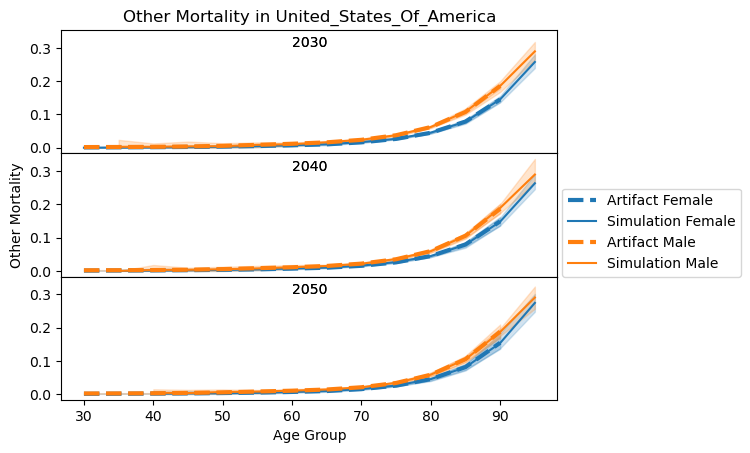

In [32]:
age_group_plot("Other Mortality", sim_ocmr, art_ocmr)

In [33]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[
                (sim_data.location == location)
                & (sim_data.age_start == age_start)
                & (sim_data.sex == sex)
            ]

            plt.plot(plot_data.event_year, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.title(
                f"{measure} in {location} Over Time Among Age Start Group {age_start}"
            )
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

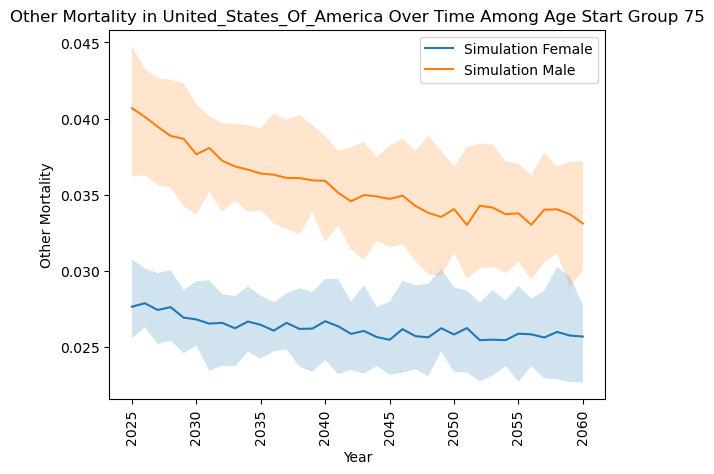

<Figure size 640x480 with 0 Axes>

In [34]:
over_time_plot("Other Mortality", sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [35]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]


def calculate_emr():
    person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
    infected = (
        person_time_total.loc[
            person_time_total.sub_entity == "alzheimers_disease_state"
        ]
        .groupby(cols)
        .sum(numeric_only=True)
    )
    assert len(infected) > 0

    deaths0 = load_df("deaths")
    deaths = (
        deaths0.loc[deaths0.sub_entity == "alzheimers_disease_state"]
        .groupby(cols)
        .sum(numeric_only=True)
    )
    assert len(deaths) > 0

    mr = (deaths / infected)[["value"]].reset_index()

    mr = mr.merge(age_dictionary, on=["age_group"])
    mr = mr.loc[mr["age_group_id"].isin(age_group_ids)]
    mr1 = (
        mr.groupby([c for c in cols if c != "input_draw"] + ["age_start"])
        .describe(percentiles=[0.025, 0.975])["value"]
        .reset_index()
    )
    return mr1


sim_emr = calculate_emr()

/tmp/ipykernel_1580163/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_1580163/1623663996.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cols)
/tmp/ipykernel_1580163/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_1580163/1623663996.py:18: F

In [48]:
def load_artifact_cause_data(measure, cause="alzheimers_disease_and_other_dementias"):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir)  # , filter_terms=["year_start==2021"])
        # display(art.keys)
        key = f"cause.{cause}.{measure}"
        data = art.load(key)
        data = (
            data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(["mean", "2.5%", "97.5%"])
            .reset_index()
        )
        data = data.merge(age_dictionary, on=["age_start", "age_end"])
        #         data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data["measure"] = measure
        data["location"] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [49]:
art_emr = load_artifact_cause_data("excess_mortality_rate", "alzheimers")
# art_emr

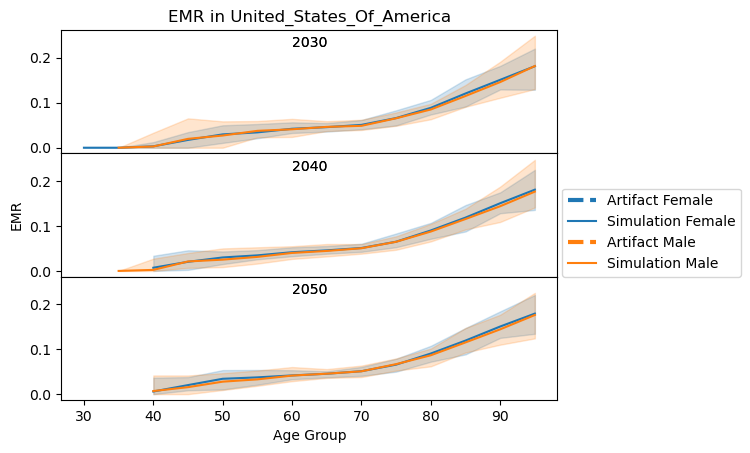

In [50]:
age_group_plot("EMR", sim_emr, art_emr, art_year=2021)

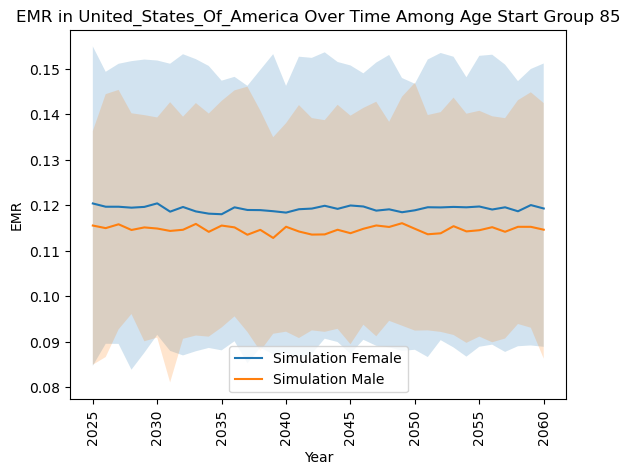

<Figure size 640x480 with 0 Axes>

In [51]:
over_time_plot("EMR", sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [40]:
# art.keys

In [52]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("cause.alzheimers.population_incidence_rate").droplevel(
            ["year_start", "year_end"]
        ),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_incidence_data.append(df)

art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f"draw_{i}"] *= art_incidence_data[f"draw_{i}_pop"]
    del art_incidence_data[f"draw_{i}_pop"]

In [53]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load("population.structure").reset_index()
    temp["location"] = temp.location.str.replace(" ", "_").str.title()
    #     import pdb; pdb.set_trace()
    df_prev_pop = pd.merge(
        art.load("population.scaling_factor").query("year_start == 2023"),
        art.load("population.structure")
        .query("year_start==2025")
        .droplevel(["year_start", "year_end"]),
        left_index=True,
        right_index=True,
        suffixes=["_prev", "_pop"],
    )
    prev = (
        (
            df_prev_pop.filter(like="draw_").filter(like="_prev")
            * df_prev_pop.filter(like="draw_").filter(like="_pop").values
        ).mean(axis=1)
    ).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / (prev + 0.01)
    temp["ratio"] = ratio

    temp = temp.rename(columns={"year_start": "event_year"})
    temp = temp.merge(age_dictionary, on=["age_start", "age_end"])
    temp = temp.loc[temp["age_group_id"].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [54]:
scale.groupby(
    "location"
).ratio.describe() / 5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
United_States_Of_America,168.0,2000000.0,0.0,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0


In [72]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("counts_new_simulants")
new_sims

,age_group,event_year,sex,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.0
1,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.0
2,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.0
3,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.0
4,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.0
...,...,...,...,...,...,...,...,...,...
404995,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.0
404996,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.0
404997,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.0
404998,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.0


/tmp/ipykernel_1580163/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location
0,25_to_29,2025,Female,2,baseline,2,0.0,United_States_Of_America
1,25_to_29,2025,Female,2,baseline,13,0.0,United_States_Of_America
2,25_to_29,2025,Female,2,baseline,24,0.0,United_States_Of_America
3,25_to_29,2025,Female,2,baseline,41,0.0,United_States_Of_America
4,25_to_29,2025,Female,2,baseline,46,0.0,United_States_Of_America
...,...,...,...,...,...,...,...,...
674995,95_plus,2060,Male,499,baseline,446,0.0,United_States_Of_America
674996,95_plus,2060,Male,499,baseline,457,0.0,United_States_Of_America
674997,95_plus,2060,Male,499,baseline,460,0.0,United_States_Of_America
674998,95_plus,2060,Male,499,baseline,480,0.0,United_States_Of_America


In [56]:
trans = load_df("transition_count_alzheimers_disease_and_other_dementias")
new_ad_dementia = trans[
    trans.sub_entity
    == "alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state"
]

/tmp/ipykernel_1580163/94018067.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


In [73]:
new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_ad_dementia = new_ad_dementia.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)

In [74]:
display(new_sims)
display(new_ad_dementia)

,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location,ratio
0,30_to_34,2025,Female,2,baseline,2,0.0,United_States_Of_America,10000000.0
1,30_to_34,2025,Female,2,baseline,13,0.0,United_States_Of_America,10000000.0
2,30_to_34,2025,Female,2,baseline,24,0.0,United_States_Of_America,10000000.0
3,30_to_34,2025,Female,2,baseline,41,0.0,United_States_Of_America,10000000.0
4,30_to_34,2025,Female,2,baseline,46,0.0,United_States_Of_America,10000000.0
...,...,...,...,...,...,...,...,...,...
454995,95_plus,2050,Male,499,baseline,446,0.0,United_States_Of_America,10000000.0
454996,95_plus,2050,Male,499,baseline,457,0.0,United_States_Of_America,10000000.0
454997,95_plus,2050,Male,499,baseline,460,0.0,United_States_Of_America,10000000.0
454998,95_plus,2050,Male,499,baseline,480,0.0,United_States_Of_America,10000000.0


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location,ratio,total_incidence
0,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,2,baseline,2,11.0,United_States_Of_America,10000000.0,0.000001
1,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,2,baseline,13,0.0,United_States_Of_America,10000000.0,0.000000
2,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,2,baseline,24,0.0,United_States_Of_America,10000000.0,0.000000
3,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,2,baseline,41,0.0,United_States_Of_America,10000000.0,0.000000
4,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,2,baseline,46,0.0,United_States_Of_America,10000000.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454995,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,499,baseline,446,0.0,United_States_Of_America,10000000.0,0.000000
454996,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,499,baseline,457,0.0,United_States_Of_America,10000000.0,0.000000
454997,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,499,baseline,460,0.0,United_States_Of_America,10000000.0,0.000000
454998,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,499,baseline,480,0.0,United_States_Of_America,10000000.0,0.000000


In [76]:
new_sims["total_incidence"] = new_sims["value"] / new_sims["ratio"]
new_ad_dementia["total_incidence"] = new_ad_dementia["value"] / new_sims["ratio"]


def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = (
        df.groupby([c for c in cols if c != "input_draw"])
        .describe(percentiles=[0.025, 0.975])["total_incidence"]
        .reset_index()
    )

    df = df.merge(age_dictionary, on=["age_group"])
    df = df.loc[df["age_group_id"].isin(age_group_ids)]

    return df


new_sims_summary = summarize(new_sims)
new_sims_summary

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,2025,United_States_Of_America,30_to_34,Female,25.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,11,11,30 to 34,30.0,35.0
1,2025,United_States_Of_America,30_to_34,Male,25.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,11,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,35_to_39,Female,25.0,4.000000e-09,2.000000e-08,0.000000,0.000000,0.000000,4.000000e-08,1.000000e-07,12,12,35 to 39,35.0,40.0
3,2025,United_States_Of_America,35_to_39,Male,25.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,12,12,35 to 39,35.0,40.0
4,2025,United_States_Of_America,40_to_44,Female,25.0,7.696000e-06,1.412881e-06,0.000004,0.000005,0.000008,9.920000e-06,1.010000e-05,13,13,40 to 44,40.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2050,United_States_Of_America,85_to_89,Male,25.0,8.452800e-05,4.186973e-05,0.000019,0.000020,0.000079,1.451200e-04,1.468000e-04,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,25.0,8.995600e-05,4.323807e-05,0.000024,0.000029,0.000087,1.691000e-04,1.691000e-04,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,25.0,3.689200e-05,1.572387e-05,0.000012,0.000012,0.000036,6.150000e-05,6.690000e-05,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,25.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,24,235,95 plus,95.0,125.0


In [77]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,2025,United_States_Of_America,30_to_34,Female,25.0,8.400000e-07,4.020779e-07,1.000000e-07,2.200000e-07,9.000000e-07,1.440000e-06,1.500000e-06,11,11,30 to 34,30.0,35.0
1,2025,United_States_Of_America,30_to_34,Male,25.0,3.960000e-07,3.207803e-07,1.000000e-07,1.000000e-07,3.000000e-07,1.080000e-06,1.200000e-06,11,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,35_to_39,Female,25.0,4.880000e-07,2.773686e-07,0.000000e+00,6.000000e-08,5.000000e-07,9.800000e-07,1.100000e-06,12,12,35 to 39,35.0,40.0
3,2025,United_States_Of_America,35_to_39,Male,25.0,2.640000e-07,1.577973e-07,0.000000e+00,0.000000e+00,2.000000e-07,5.400000e-07,6.000000e-07,12,12,35 to 39,35.0,40.0
4,2025,United_States_Of_America,40_to_44,Female,25.0,4.640000e-07,3.147486e-07,1.000000e-07,1.000000e-07,4.000000e-07,1.180000e-06,1.300000e-06,13,13,40 to 44,40.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2050,United_States_Of_America,85_to_89,Male,25.0,6.854400e-05,8.130810e-06,5.590000e-05,5.626000e-05,6.880000e-05,7.950000e-05,8.070000e-05,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,25.0,7.350800e-05,1.004469e-05,5.300000e-05,5.654000e-05,7.290000e-05,9.116000e-05,9.200000e-05,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,25.0,3.116800e-05,3.499014e-06,2.290000e-05,2.374000e-05,3.190000e-05,3.578000e-05,3.590000e-05,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,25.0,2.074000e-05,4.686861e-06,1.400000e-05,1.466000e-05,2.000000e-05,3.046000e-05,3.070000e-05,24,235,95 plus,95.0,125.0


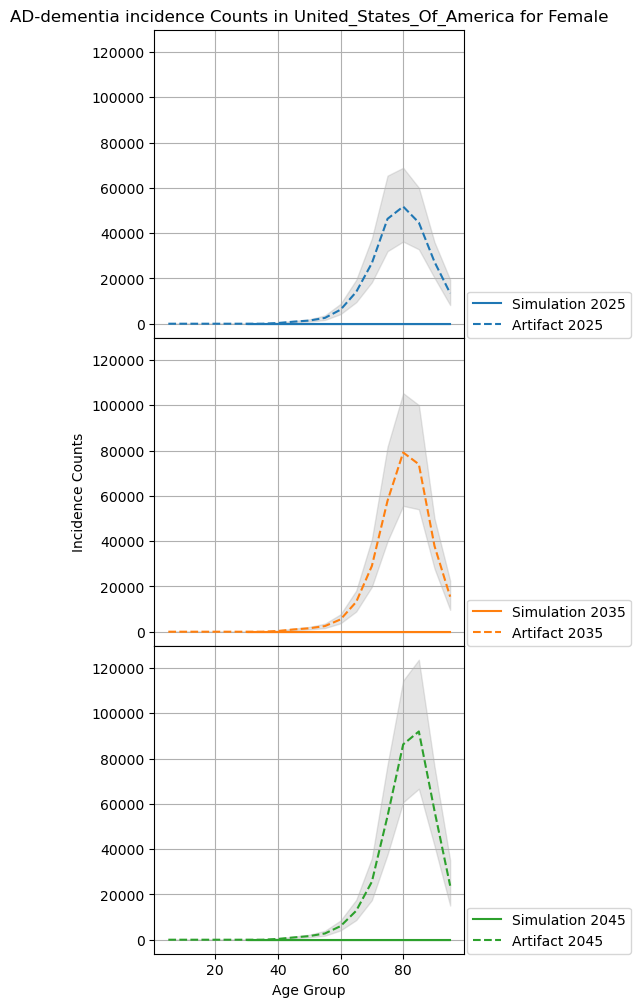

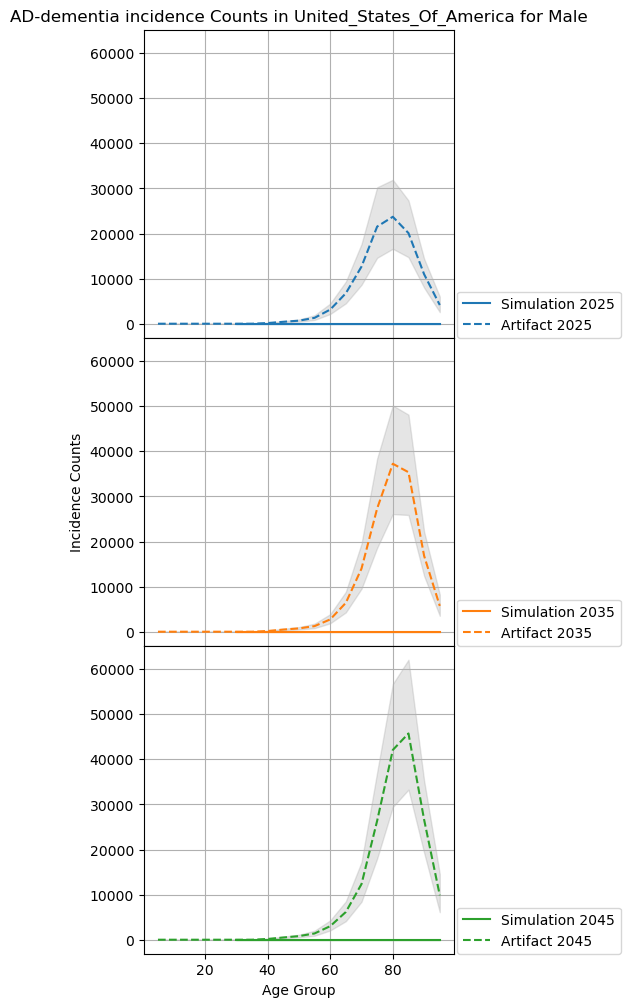

In [78]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4, 12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f"C{i}"
            plot_data = new_ad_dementia_summary.query(
                "location == @location and event_year == @year and sex == @sex"
            )

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            ax[i].fill_between(
                plot_data.age_start,
                plot_data["2.5%"],
                plot_data["97.5%"],
                alpha=0.2,
                color=color,
            )
            ax[i].fill_between(
                art_plot.age_start,
                art_plot["upper"],
                art_plot["lower"],
                alpha=0.2,
                color="grey",
            )
            ax[i].plot(
                plot_data.age_start,
                plot_data["mean"],
                label=f"Simulation {year}",
                color=color,
            )
            ax[i].plot(
                art_plot.age_start,
                art_plot["mean"],
                label=f"Artifact {year}",
                color=color,
                linestyle="--",
            )
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
            #             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))

#             ax[i].semilogy()

## Verifying Overall Prevalence

In [79]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("population.scaling_factor").droplevel(["year_start", "year_end"]),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_prev_data.append(df)

art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f"draw_{i}"] *= art_prev_data[f"draw_{i}_pop"]
    del art_prev_data[f"draw_{i}_pop"]
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                  
Male   30        35      United States of America 2021       2022           0.159966   
                                                  2022       2023           0.160666   
                                                  2023       2024           0.161063   
                                                  2024       2025           0.161282   
                                                  2025       2026           0.161520   
...                                                                              ...   
Female 90        95      United States of America 2046       2047      764886.418908   
                                                  2047       2048      776180.192160   
                                                  2048       2049      788319.449677   
                                                  2049       2050      798539.193616   
                                                  2050       2051      804671.185661   

                                                                              draw_1  \
sex    age_start age_end location                 year_start year_end                  
Male   30        35      United States of America 2021       2022           0.458818   
                                                  2022       2023           0.460631   
                                                  2023       2024           0.461539   
                                                  2024       2025           0.462025   
                                                  2025       2026           0.462522   
...                                                                              ...   
Female 90        95      United States of America 2046       2047      793181.895653   
                                                  2047       2048      806347.891748   
                                                  2048       2049      820683.742797   
                                                  2049       2050      833307.201675   
                                                  2050       2051      841379.050029   

                                                                              draw_2  \
sex    age_start age_end location                 year_start year_end                  
Male   30        35      United States of America 2021       2022           0.079378   
                                                  2022       2023           0.079746   
                                                  2023       2024           0.079968   
                                                  2024       2025           0.080120   
                                                  2025       2026           0.080299   
...                                                                              ...   
Female 90        95      United States of America 2046       2047      678142.252928   
                                                  2047       2048      689451.916566   
                                                  2048       2049      702125.407716   
                                                  2049       2050      713738.403074   
                                                  2050       2051      721379.628511   

                                                                              draw_3  \
sex    age_start age_end location                 year_start year_end                  
Male   30        35      United States of America 2021       2022           0.374640   
                                                  2022       2023           0.376279   
                                                  2023       2024           0.377245   
                                                  2024       2025           0.377868   
                                                  2025       2026           0.378604   
...                        

In [80]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("person_time_alzheimers_disease_and_other_dementias")
new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_sims["total_prev"] = new_sims["value"] / new_sims["ratio"]
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = (
    new_sims.groupby([c for c in cols if c != "input_draw"])
    .describe(percentiles=[0.025, 0.975])["total_prev"]
    .reset_index()
)

new_sims = new_sims.merge(age_dictionary, on=["age_group"])
new_sims = new_sims.loc[new_sims["age_group_id"].isin(age_group_ids)]
new_sims.tail()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10934995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,3.986311
10934998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.996578


/tmp/ipykernel_1580163/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,United_States_Of_America,85_to_89,Male,25.0,0.001339,0.000112,0.001141,0.001167,0.001332,0.001492,0.001518,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,25.0,0.001479,0.000125,0.001308,0.001308,0.001464,0.001710,0.001739,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,25.0,0.000618,0.000050,0.000520,0.000526,0.000636,0.000689,0.000704,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,25.0,0.000427,0.000067,0.000329,0.000338,0.000404,0.000568,0.000586,24,235,95 plus,95.0,125.0
727,2050,United_States_Of_America,95_plus,Male,25.0,0.000154,0.000023,0.000097,0.000111,0.000149,0.000190,0.000196,24,235,95 plus,95.0,125.0


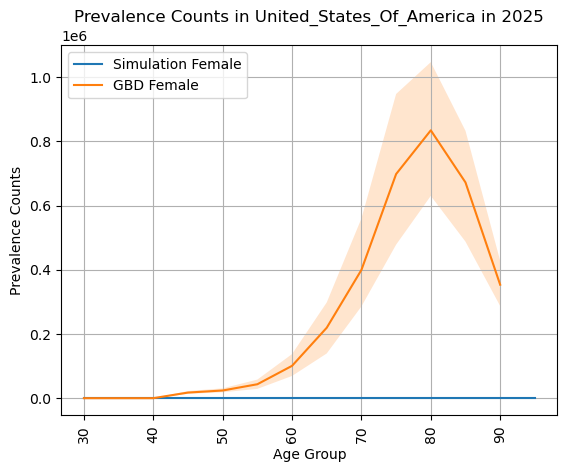

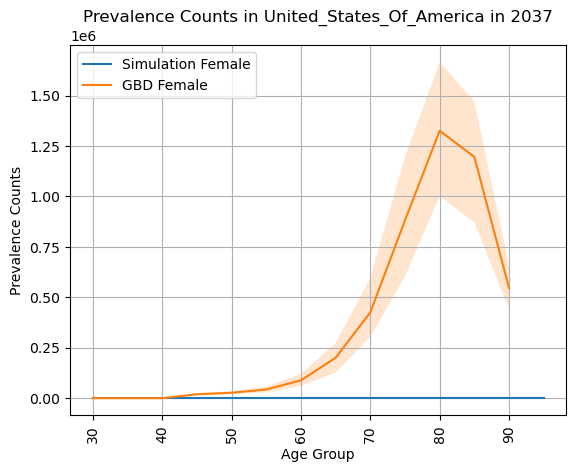

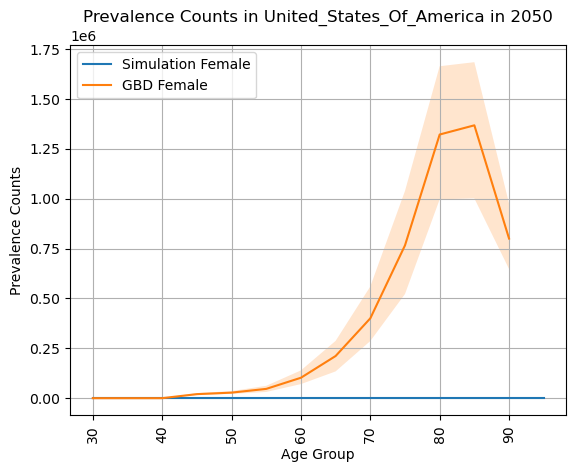

<Figure size 640x480 with 0 Axes>

In [81]:
for location in new_sims.location.unique():
    for year in [2025, 2037, 2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[
                (new_sims.location == location)
                & (new_sims.event_year == year)
                & (new_sims.sex == sex)
            ]
            #             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            plt.plot(plot_data.age_start, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.age_start, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.plot(art_plot.age_start, art_plot["mean"], label=f"GBD {sex}")
            plt.fill_between(
                art_plot.age_start, art_plot["upper"], art_plot["lower"], alpha=0.2
            )

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
        #             plt.semilogy()
        plt.figure()

# Dementia Prevalence

In [54]:
# swtich from this
# art.load(
#     'population.scaling_factor'
#         )#.droplevel(['year_start', 'year_end'])

# to this
# art.load(
#     'cause.alzheimers.prevalence'
#         )#.droplevel(['year_start', 'year_end'])

# ?

In [82]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("cause.alzheimers.prevalence").droplevel(["year_start", "year_end"]),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_prev_data.append(df)

art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f"draw_{i}"] *= art_prev_data[f"draw_{i}_pop"]
    del art_prev_data[f"draw_{i}_pop"]


art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United States of America 2046       2047      55173.295736   
                                                  2047       2048      56569.197309   
                                                  2048       2049      58017.307994   
                                                  2049       2050      59455.918860   
                                                  2050       2051      60791.531100   

                                                                             draw_1  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United States of America 2046       2047      62960.360100   
                                                  2047       2048      64778.886343   
                                                  2048       2049      66721.023153   
                                                  2049       2050      68637.274127   
                                                  2050       2051      70358.671211   

                                                                             draw_2  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United States of America 2046       2047      53415.859578   
                                                  2047       2048      54902.012715   
                                                  2048       2049      56443.222505   
                                                  2049       2050      57958.095674   
                                                  2050       2051      59376.361251   

                                                                             draw_3  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                     

In [56]:
# t[t.sub_entity == 'alzheimers_disease_state']

In [83]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("person_time_alzheimers_disease_and_other_dementias")

# restrict to dementia state only
new_sims = new_sims[new_sims.sub_entity == "alzheimers_disease_state"]

new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_sims["total_prev"] = new_sims["value"] / new_sims["ratio"]
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = (
    new_sims.groupby([c for c in cols if c != "input_draw"])
    .describe(percentiles=[0.025, 0.975])["total_prev"]
    .reset_index()
)

new_sims = new_sims.merge(age_dictionary, on=["age_group"])
new_sims = new_sims.loc[new_sims["age_group_id"].isin(age_group_ids)]
new_sims.tail()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10934995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,3.986311
10934998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.996578


/tmp/ipykernel_1580163/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,United_States_Of_America,85_to_89,Male,25.0,0.000720,0.000057,0.000625,0.000637,0.000702,0.000834,0.000865,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,25.0,0.000889,0.000062,0.000767,0.000800,0.000887,0.001013,0.001021,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,25.0,0.000353,0.000025,0.000291,0.000306,0.000358,0.000395,0.000404,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,25.0,0.000264,0.000041,0.000200,0.000213,0.000256,0.000352,0.000358,24,235,95 plus,95.0,125.0
727,2050,United_States_Of_America,95_plus,Male,25.0,0.000092,0.000014,0.000065,0.000070,0.000092,0.000116,0.000122,24,235,95 plus,95.0,125.0


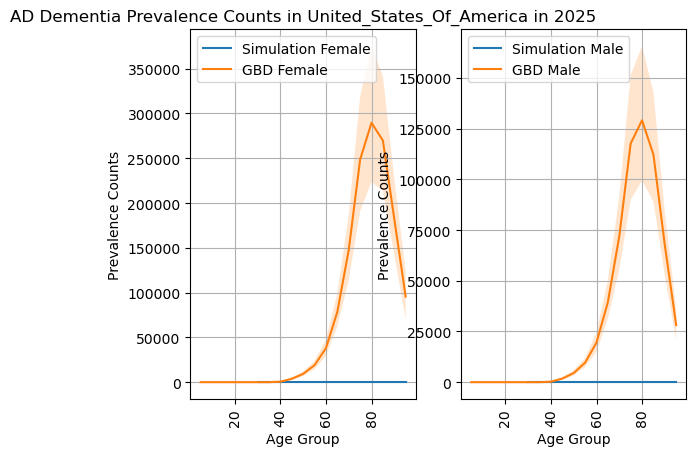

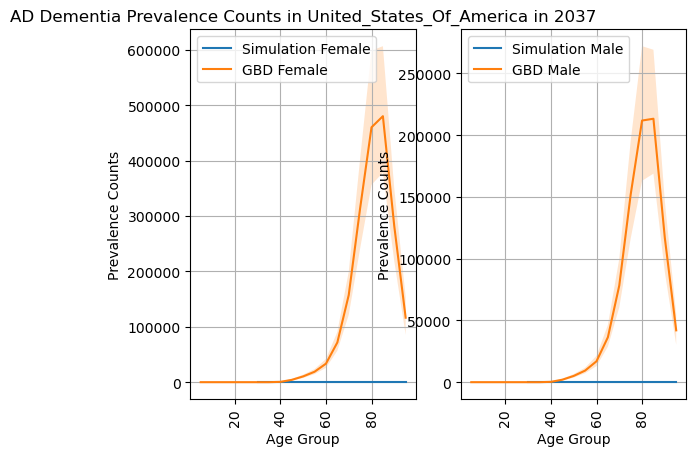

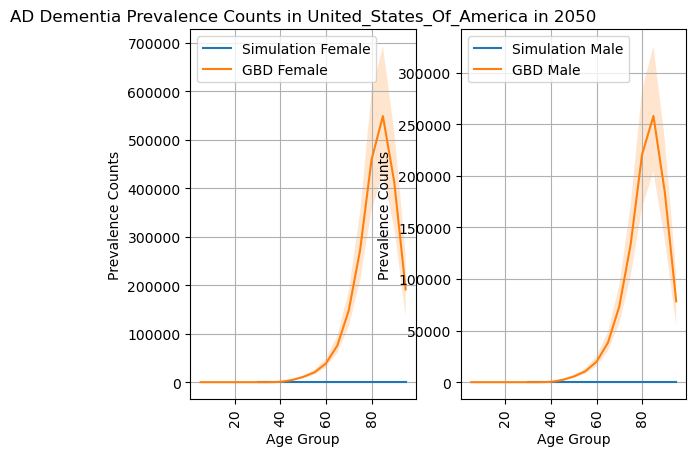

<Figure size 640x480 with 0 Axes>

In [84]:
for location in new_sims.location.unique():
    for year in [2025, 2037, 2050]:
        for i, sex in enumerate(new_sims.sex.unique()):
            plt.subplot(1, 2, i + 1)
            plot_data = new_sims.loc[
                (new_sims.location == location)
                & (new_sims.event_year == year)
                & (new_sims.sex == sex)
            ]
            #             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            plt.plot(plot_data.age_start, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.age_start, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.plot(art_plot.age_start, art_plot["mean"], label=f"GBD {sex}")
            plt.fill_between(
                art_plot.age_start, art_plot["upper"], art_plot["lower"], alpha=0.2
            )

            if i == 0:
                plt.title(f"AD Dementia Prevalence Counts in {location} in {year}")
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
        #             plt.semilogy()
        plt.figure()

## Total Sim Population Over Time

In [85]:
cols = ["input_draw", "event_year", "location"]  # , 'age_group']

person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10934995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,3.986311
10934998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.996578


/tmp/ipykernel_1580163/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,event_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,United_States_Of_America,25.0,101521.229405,150.225996,101161.106092,101222.694593,101562.228611,101732.743053,101772.506502
1,2026,United_States_Of_America,25.0,108627.426256,773.597440,106855.052704,107007.828063,108873.122519,109509.836003,109538.836413
2,2027,United_States_Of_America,25.0,115423.647584,1335.380194,112643.175907,112783.394387,115878.565366,117005.894045,117052.533881
3,2028,United_States_Of_America,25.0,121939.770787,1890.293001,118167.704312,118236.767146,122486.373717,124554.571389,124584.169747
4,2029,United_States_Of_America,25.0,128192.000219,2362.452380,123455.047228,123689.741273,128946.688569,131403.053251,131606.056126
5,2030,United_States_Of_America,25.0,134285.574483,2862.945113,128332.298426,129026.813415,134975.485284,138352.289117,138578.611910
6,2031,United_States_Of_America,25.0,140211.404791,3307.181073,133262.866530,134264.726078,140846.822724,145064.239836,145220.303901
7,2032,United_States_Of_America,25.0,145797.840602,3791.143337,138099.258042,139307.409172,146265.713895,151491.169336,151747.389459
8,2033,United_States_Of_America,25.0,151020.744805,4183.521224,142841.971253,144024.410678,151524.654346,157545.677755,157574.379192
9,2034,United_States_Of_America,25.0,155855.661383,4507.533289,147349.492129,148490.972211,156041.642710,162922.613005,163068.511978


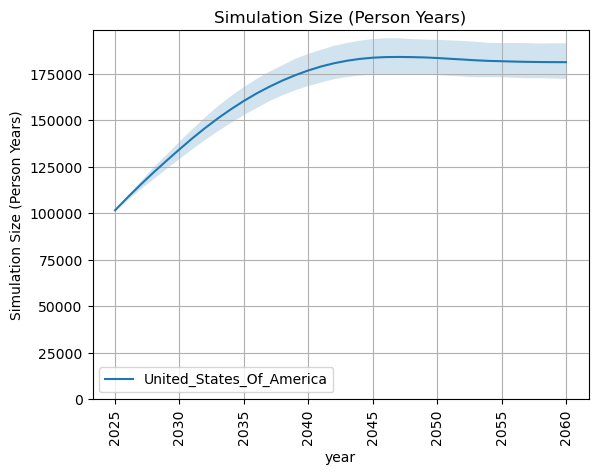

In [86]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.event_year, plot_data["mean"], label=location)
    plt.fill_between(
        plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
    )
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Decompose person-time by state

In [87]:
cols = ["input_draw", "event_year", "sub_entity", "location"]  # , 'age_group']

person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10934995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,3.986311
10934998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.996578


/tmp/ipykernel_1580163/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_1580163/4293227660.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_1580163/4293227660.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total.groupby([c 

,event_year,sub_entity,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,alzheimers_blood_based_biomarker_state,United_States_Of_America,25.0,45876.536947,778.684933,43781.152635,44151.281588,45916.818617,47164.035592,47291.099247
1,2025,alzheimers_disease_state,United_States_Of_America,25.0,32979.765311,682.360095,31424.585900,31715.187953,33017.615332,34380.136345,34555.334702
2,2025,alzheimers_mild_cognitive_impairment_state,United_States_Of_America,25.0,22664.927146,215.238966,22304.405202,22325.632307,22651.712526,23141.929090,23269.590691
3,2026,alzheimers_blood_based_biomarker_state,United_States_Of_America,25.0,44523.782396,1015.830318,41966.882957,42359.733881,44538.053388,46131.780424,46405.639973
4,2026,alzheimers_disease_state,United_States_Of_America,25.0,38639.668830,858.897880,37170.852841,37226.760849,38570.546201,40273.697467,41022.625599
...,...,...,...,...,...,...,...,...,...,...,...
103,2059,alzheimers_disease_state,United_States_Of_America,25.0,97080.240055,2913.389447,89996.944559,91492.708008,96863.364819,101637.171253,102776.558522
104,2059,alzheimers_mild_cognitive_impairment_state,United_States_Of_America,25.0,36526.545435,1740.040031,33723.192334,33796.141821,36474.245038,39138.296509,39199.885010
105,2060,alzheimers_blood_based_biomarker_state,United_States_Of_America,25.0,47529.640082,3151.788067,41007.676934,41775.141410,47787.394935,51964.948939,52300.396988
106,2060,alzheimers_disease_state,United_States_Of_America,25.0,97118.169802,2903.620131,89922.699521,91606.517180,96936.114990,101728.358111,102719.753593


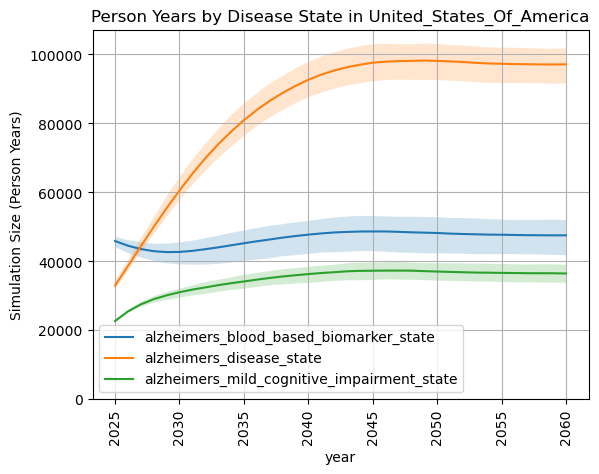

In [88]:
for location in person_time_total.location.unique():
    for sub_entity in person_time_total.sub_entity.unique():
        plot_data = person_time_total.query(
            "location == @location and sub_entity == @sub_entity"
        )
        plt.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
        plt.fill_between(
            plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
        )
    plt.title(f"Person Years by Disease State in {location}")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Did the fix to initialization work?  Seems so